# TMDX 日足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = 'TMDX'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1y')
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-27 00:00:00-05:00,75.000000,77.175003,72.059998,72.120003,2012400,0.0,0.0
2025-02-28 00:00:00-05:00,73.660004,80.220001,73.000000,76.320000,2807500,0.0,0.0
2025-03-03 00:00:00-05:00,76.430000,77.169998,68.459999,69.330002,2199900,0.0,0.0
2025-03-04 00:00:00-05:00,66.000000,69.760002,63.290001,69.110001,1642500,0.0,0.0
2025-03-05 00:00:00-05:00,69.599998,69.980003,66.309998,67.732399,579822,0.0,0.0


## 日足チャートとパラボリック SAR

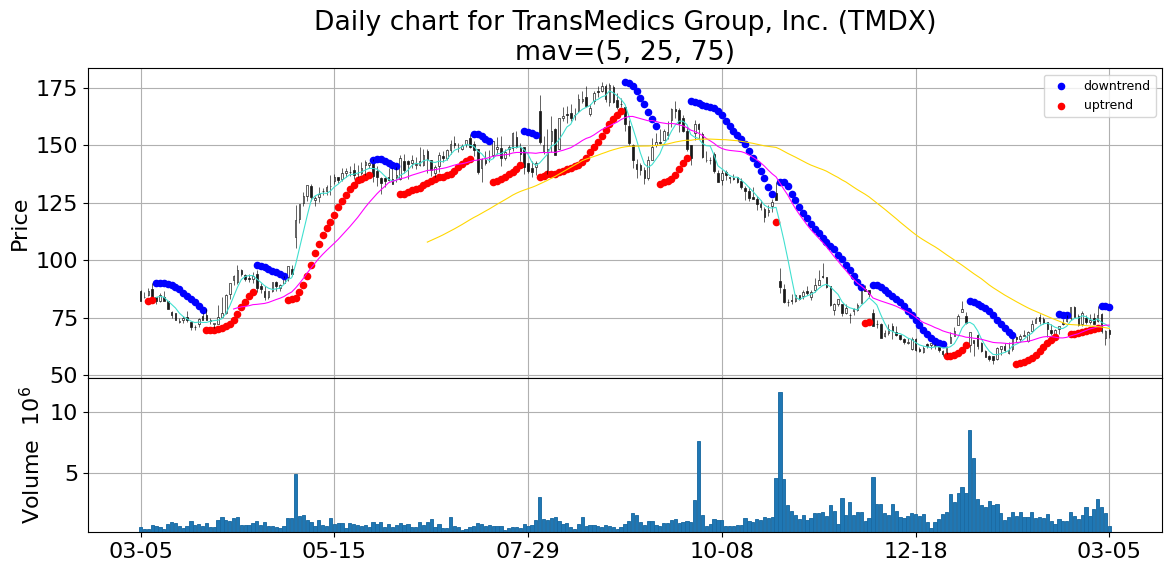

In [3]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=ax[1],
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax[0].legend(loc='best', fontsize=9)


plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [5]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-27 00:00:00-05:00,59.844501,64.400002,59.299999,61.07,1322589,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-01-24 00:00:00-05:00    60.82
2025-01-27 00:00:00-05:00    61.07
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-01-24 00:00:00-05:00     NaN
2025-01-27 00:00:00-05:00    0.25
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-01-24 00:00:00-05:00    59.854
2025-01-27 00:00:00-05:00    60.628
Name: Close, dtype: float64

In [9]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-01-24 00:00:00-05:00    63.8474
2025-01-27 00:00:00-05:00    63.6620
Name: Close, dtype: float64